In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import sklearn as sk
from sklearn.model_selection import train_test_split


# 1. Mon premier est ... linéaire !

In [82]:
class Loss(object):
    def forward(self, y, yhat):
        pass

    def backward(self, y, yhat):
        pass

class MSELoss(Loss):
    def forward(self, y, yhat):
        f = np.mean((y-yhat)**2)/2
        return f

    def backward(self, y, yhat):
        g = (yhat-y)/len(y)
        return g


class Module(object):
    def __init__(self):
        self.W = None
        self.b = None
        self.gradientW = None
        self.gradientb = None

    def zero_grad(self):
        ## Annule gradient
        self.gradientW = None
        self.gradientb = None

    def forward(self, X):
        ## Calcule la passe forward
        pass

    def update_parameters(self, gradient_step=1e-3):
        pass

    def backward_update_gradient(self, input, delta):
        ## Met a jour la valeur du gradient
        pass

    def backward_delta(self, input, delta):
        ## Calcul la derivee de l'erreur
        pass
    
class LinearModule(Module):
    """
    N : la taille du mini-batch
    d : le nombre de dimensions d'un échantillon
    d' : le nombre de neurones dans le module
    """
    
    def __init__(self, d, dprime, N):
        Module.__init__(self)
        self.W = np.random.rand(d, dprime) - 0.5#W est de taille d*d'
        self.b = np.random.rand(1, dprime) - 0.5 #b est de taille 1*d' (on réplique N fois la première ligne par broadcasting lors des opérations)
        self.gradientW = None
        self.gradientb = None

    def forward(self, X):
        ## Calcule la passe forward
        self.input = X
        forwa = X@self.W + self.b
        return forwa
    
    def update_parameters(self, gradient_step=1e-3):
        ## Calcule la mise a jour des parametres selon le gradient calcule et le pas de gradient_step
        self.W -= gradient_step * self.gradientW
        self.b -= gradient_step * self.gradientb
        self.zero_grad()

    def backward_update_gradient(self, input, delta_sortie):
        ## Calcule le gradient du coût par rapport aux paramètres et l’additionne au gradient (gradientW et gradientb)
        # - en fonction de l’entrée input et des δ de la couche suivante delta
        # Fait une moyenne sur les échantillons
        n = len(input)
        self.gradientW = (input.T@delta_sortie)/n 
        self.gradientb = np.sum(delta_sortie,axis=0,keepdims=True)/n  

    def backward_delta(self, entre, delta_sortie):
        ## Calcule le gradient du coût par rapport aux entrées en fonction de l’entrée "input" =error et des deltas de la couche suivante "delta"
        back = delta_sortie@self.W.T
        return back

## Tests module linéaire

# 2. Mon second est ... non-linéaire !

In [83]:
class TanH(Module):

    def __init__(self):
        Module.__init__(self)

    def forward(self, X):
        ## Calcule la passe forward
        self.input = X
        return np.tanh(X)

    def backward_delta(self, input, delta):
        ## Calcule le gradient du coût par rapport aux entrées en fonction de l’entrée "input" et des deltas de la couche suivante "delta"
        return (1-np.tanh(input)**2) * delta
    
class Sigmoide(Module):
    def __init__(self):
        Module.__init__(self)


    def forward(self, X):
        ## Calcule la passe forward
        self.input = X
        return 1/(1 + np.exp(-X))


    def backward_delta(self, input, delta):
        return self.forward(input) * (1-self.forward(input))
        ## Calcule le gradient du coût par rapport aux entrées en fonction de l’entrée "input" et des deltas de la couche suivante "delta"
        #return prod_mat(stretch_vect(delta, len(input)),div_mat(np.exp(-input), 1+np.exp(-input)))

dimensions de X: (10000, 2)
dimensions de y: (10000, 1)


100%|██████████| 1000/1000 [00:03<00:00, 292.91it/s]


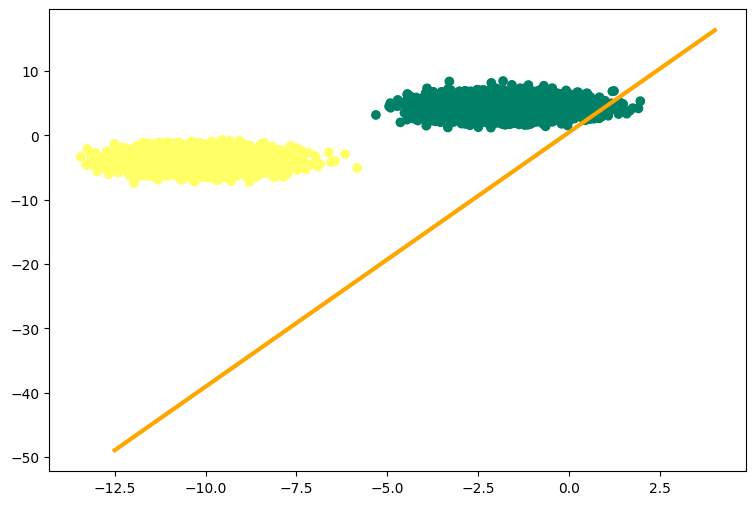

In [111]:
#visualiser dataset
X, y = make_blobs(n_samples=10000, n_features=2, centers=2, random_state=1)
y = y.reshape((y.shape[0], 1))
print('dimensions de X:', X.shape)
print('dimensions de y:', y.shape)

# réseau neurone apprentissage à améliorer des erreurs dedans
ml = LinearModule(2,1,100)
al = Sigmoide()
for i in tqdm(range(1000)):
    ml.zero_grad()
    yhat = al.forward(ml.forward(X))
    mse = MSELoss()
    grad_error = mse.backward(y,yhat)
    grad_sig = al.backward_delta(al.input,grad_error)
    grad_delta = ml.backward_delta(ml.input,grad_sig)
    ml.backward_update_gradient(ml.input,grad_error)
    ml.update_parameters()
yo = np.where(yhat>=0.5,1,0)

#afficher frontière de décision simplement
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(X[:,0], X[:, 1], c=y, cmap='summer')
x1 = np.linspace(-12.5, 4, 100).reshape(-1,1)
x2 = (( ml.W[0] * x1 - ml.b) / ml.W[1]).reshape(-1,1)
ax.plot(x1, x2, c='orange', lw=3)
plt.show()

#module 3d
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d( 
    x=X[:, 0].flatten(),
    y=X[:, 1].flatten(),
    z=y.flatten(),
    mode='markers',
    marker=dict(
        size=5,
        color=y.flatten(),                
        colorscale='YlGn',  
        opacity=0.8,
        reversescale=True
    )
)])

fig.update_layout(template= "plotly_dark", margin=dict(l=0, r=0, b=0, t=0))
fig.layout.scene.camera.projection.type = "orthographic"
fig.show()

X0 = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
X1 = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
xx0, xx1 = np.meshgrid(X0, X1)
Z = ml.W[0] * xx0 + ml.W[1] * xx1 + ml.b
A = 1 / (1 + np.exp(-Z))

fig = (go.Figure(data=[go.Surface(z=A, x=xx0, y=xx1, colorscale='YlGn', opacity = 0.7, reversescale=True)]))

fig.add_scatter3d(x=X[:, 0].flatten(), y=X[:, 1].flatten(), z=y.flatten(), mode='markers', marker=dict(size=5, color=y.flatten(), colorscale='YlGn', opacity = 0.9, reversescale=True))


fig.update_layout(template= "plotly_dark", margin=dict(l=0, r=0, b=0, t=0))
fig.layout.scene.camera.projection.type = "orthographic"
fig.show()
# on peut faire une animation aussi

In [97]:
class Sequentiel(object):
    def __init__(self):
        self.layers = []
    
    def add(self, layer):
        # initialiser 
        self.layers.append(layer)

class Optim(object):
    def __init__(self, net, loss, eps):
        self.net = net
        self.loss = loss
        self.eps = eps
    
    def step(self, batch_x, batch_y):
        output = batch_x
        for layer in self.net.layers:
            output = layer.forward(output)
        cost = self.loss.forward(batch_y, output)  # faire append pour tracer courbe loss
        delta = self.loss.backward(batch_y, output)
        for layer in reversed(self.net.layers):
            layer.backward_update_gradient(layer.input, delta)
            delta = layer.backward_delta(layer.input, delta)
            layer.update_parameters(gradient_step=self.eps)
        return cost

class SGD():
    def __init__(self,training_data, net, t_batch, epochs, loss, eps):
        self.net = net
        self.X_train = training_data[0]
        self.y_train = training_data[1]
        self.training_data = training_data
        self.t_batch = t_batch
        self.epochs = epochs
        self.loss = loss
        self.eps = eps

    
    def train(self):
        n=len(self.X_train)
        cost = []
        for i in range(self.epochs):
            p = np.random.permutation(self.X_train.shape[0])
            self.X_train, self.y_train = self.X_train[p], self.y_train[p]
            mini_batches_X = [self.X_train[k:k+self.t_batch] for k in range(0, n, self.t_batch)]
            mini_batches_y = [self.y_train[k:k+self.t_batch] for k in range(0, n, self.t_batch)]
            for mini_batch_X, mini_batch_y in zip(mini_batches_X, mini_batches_y):
                opt = Optim(self.net,self.loss,self.eps)
            cost.append(opt.step(mini_batch_X, mini_batch_y))
        return cost

    def predict(self,X_test,y_test):
        output = X_test
        for layer in self.net.layers:
            output = layer.forward(output)
        yhat = np.where(output>=0.5,1,0)
        acc = (np.where(yhat == y_test,1,0).sum())/y_test.shape[0]
        print(f'accuracy :{acc} ')
        return yhat
    


In [106]:
# creation de donnée:
X, y = make_blobs(n_samples=1000, n_features=6, centers=2, random_state=1)
y = y.reshape((y.shape[0], 1))
X_train, X_test, y_train, y_test = train_test_split(X,y)

# parametre du reseau
dim = X.shape[1]
neurone = 1 #marche pas avec 1 neurone
batch = 10
epoch = 100
eps = 1e-5
dim2 = 1
los= MSELoss()

# module
ml = LinearModule(dim,neurone,batch)
sg = TanH()
ml2 = LinearModule(dim2,neurone,batch)
sg2 = TanH()
net = Sequentiel()
net.add(ml)
net.add(sg)
net.add(ml2)
net.add(sg2)

# apprentissage
reseau = SGD([X_train,y_train], net, batch,epoch , los, eps)
r = reseau.train()

# prédiction
yhat = reseau.predict(X_test, y_test)
print(yhat)
yhat = reseau.predict(X_train, y_train)
print(y_test)



accuracy :0.54 
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]

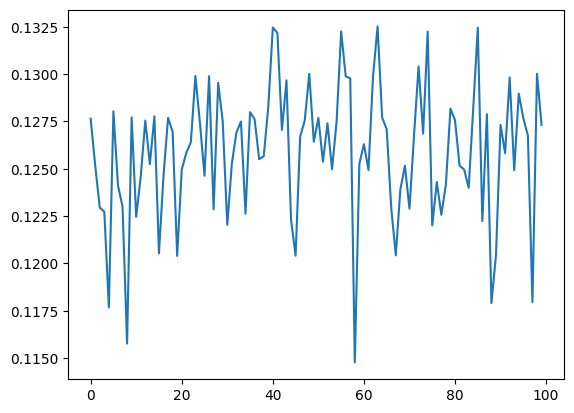

In [107]:
plt.plot(r)